In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

### Sample table

In [2]:
dfs = pd.read_excel('./raw/1-s2.0-S0092867417311224-mmc2.xlsx', skiprows=[0,1], index_col=0)
dfs.index.name='samples'
dfs = dfs.rename(columns={'Response':'response', 'Time to Death\n(weeks)':'survival', 'M Stage':'stage', 'Cohort':'cohort'})
dfs['status'] = dfs['Dead/Alive\n(Dead = True)'].map({True:'Dead', False:'Alive'})
dfs['flag'] = dfs.response.map({'PD':0, 'SD':0, 'PR':1, 'CR':1}).to_frame(name='flag')
cols = ['flag', 'response', 'cohort', 'stage', 'status','survival',]
dfs = dfs[cols]
dfs.cohort.value_counts()

cohort
NIV3-PROG     39
NIV3-NAIVE    34
Name: count, dtype: int64

### Mutation table

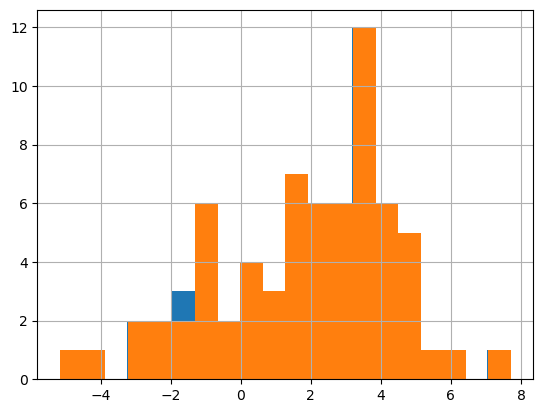

In [3]:
captureSize = 35.8 #for tmb claculation

VC_NONSYNONYMOUS_LIST = [
                         'missense_variant',
                         'stop_gained',
                         'splice_donor_variant&intron_variant ',
                         'splice_acceptor_variant&intron_variant',
                         'stop_lost',
                         'start_lost&splice_region_variant',
                         'missense_variant&splice_region_variant']

truncate_mut_LIST = ['stop_gained', 'splice_acceptor_variant&intron_variant', 'splice_donor_variant&intron_variant ']
nontruncate_mut_LIST = ['missense_variant','stop_lost']

mut = pd.read_excel('./raw/1-s2.0-S0092867417311224-mmc3.xlsx', skiprows=[0,1,2])
mut_series = mut['Variant Classification']

mut['nansynonymous_mut_flag'] = mut_series.isin(VC_NONSYNONYMOUS_LIST)
mut['truncate_mut_flag'] = mut_series.isin(truncate_mut_LIST)
mut['nontruncate_mut_flag'] = mut_series.isin(nontruncate_mut_LIST)

I_calculated_TMB1 = mut.groupby('Patient').nansynonymous_mut_flag.sum()
I_calculated_TMB2 = mut.groupby('Patient').apply(lambda x:x.truncate_mut_flag.sum()*2+x.nontruncate_mut_flag.sum())

#for tmb claculation
tmb1 = np.log2(I_calculated_TMB1/captureSize)
tmb2 = np.log2(I_calculated_TMB2/captureSize)

tmb1.hist(bins=20)
tmb2.hist(bins=20)

tmb = tmb1.to_frame('tmb.dan').join(tmb2.to_frame(name = 'tmb.wang'))

### mRNA table

In [33]:
dfm = pd.read_csv('./raw/GSE91061_BMS038109Sample.hg19KnownGene.raw.csv',index_col=0)
dfm = dfm[dfm.columns[dfm.columns.map(lambda x:'_Pre_' in x)]]
dfm.shape

(22187, 51)

In [34]:
df_samples = pd.DataFrame(dfm.columns, columns=['samples'])
df_samples['patient'] = df_samples.samples.map(lambda x:x.split('_')[0])
df_samples = df_samples.set_index('patient').join(dfs)
df_samples = df_samples[~df_samples.flag.isna()]
df_samples = df_samples.join(tmb).reset_index().set_index('samples')

In [35]:
dfm = dfm[df_samples.index]

### convert entrezgene id to gene name

In [36]:
import mygene
mg = mygene.MyGeneInfo()
entrezgene_info = mg.querymany(dfm.index.tolist(), scope='entrezgene', 
                               returnall=True, species= 'human', as_dataframe=True)

out = entrezgene_info['out'][entrezgene_info['out']._score == 26.7615]	
entrezgene_id_name_map = out.symbol

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

In [37]:
dfm.index = dfm.index.astype(str)
dfm = dfm.loc[entrezgene_id_name_map.index]
dfm.index = dfm.index.map(entrezgene_id_name_map)

In [38]:
df_mRNA = dfm

In [41]:
dfm.index.shape

(21199,)

##### counts to tpm

In [42]:
from rnanorm.datasets import load_toy_data
from rnanorm import FPKM, TPM, CPM, TMM 
from rnanorm.methods.within_sample import BaseNormalizationWithGTF
from rnanorm.annotation import GTF
from rnanorm.methods.utils import LibrarySize

gene_length = pd.read_pickle('/n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/gene_id_length.map')
gene_name = pd.read_pickle('/n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/gene_name_id.map')
gene_name_length = gene_name.map(gene_length)
common_genes = list(set(gene_name_length.keys()) & set(df_mRNA.index))
len(common_genes)

20311

In [43]:
df_mRNA = df_mRNA.loc[common_genes].T
gene_name_length = gene_name_length.loc[common_genes]
tpm = TPM(gene_lengths = gene_name_length).set_output(transform ='pandas')
df_mRNA_TPM = tpm.fit_transform(df_mRNA)
df_mRNA_TPM = df_mRNA_TPM[~(df_mRNA_TPM.T.sum() == 0)].T

In [44]:
df_mRNA_TPM

,Pt1_Pre_AD101148-6,Pt10_Pre_E9047565-6,Pt101_Pre_AD486328-5,Pt103_Pre_AE134058-2,Pt106_Pre_AD502250-5,Pt11_Pre_AD153352-6,Pt17_Pre_E9047563-6,Pt18_Pre_E9024732-6,Pt2_Pre_AD101150-6,Pt24_Pre_AD436687-5,...,Pt8_Pre_AD153354-6,Pt82_Pre_AD823914-8,Pt84_Pre_AD486532-5,Pt85_Pre_AD486329-5,Pt89_Pre_AE070951-5,Pt9_Pre_E9021024-6,Pt90_Pre_AD467873-6,Pt92_Pre_AE134060-5,Pt94_Pre_AD732850-6,Pt98_Pre_AD733586-8
KPNA1,56.580803,72.046527,37.213958,9.004647,56.870598,69.976683,52.917636,44.825964,61.011320,32.400847,...,80.052358,36.095247,37.739899,88.346776,53.289259,57.530044,48.052140,24.485681,52.224780,29.801891
CLLU1-AS1,0.508765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181725,107.923801,...,1.178754,0.000000,0.000000,0.455060,0.936361,0.582245,0.000000,0.000000,0.000000,0.000000
CHRM3,0.843416,0.033321,0.280214,0.023677,0.129534,0.343528,0.106509,0.952118,0.000000,0.098751,...,0.319762,0.170527,0.000000,0.054864,1.239800,2.711414,0.016321,1.161598,0.223398,0.085159
TCTE1,0.000000,0.046808,0.098409,0.000000,0.134081,0.000000,0.558584,0.915141,0.403964,0.000000,...,0.000000,0.754591,0.000000,0.134876,0.059471,0.474576,0.213984,0.468834,0.492380,0.609026
SCML2,1.021685,28.158906,3.041361,0.348711,0.884538,3.509087,10.407684,4.895063,4.638496,1.853602,...,2.055669,10.584042,4.069523,6.180411,3.690044,10.584743,7.382639,0.516755,1.134528,8.442776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MZT2A,16.301003,6.409348,12.939991,35.766621,10.298543,2.506905,5.826483,4.192078,15.812735,2.773263,...,4.742254,7.727883,7.606912,7.008752,8.616912,2.127361,4.930749,15.293350,6.780845,12.041120
TPH1,0.392893,0.333781,0.341874,0.000000,0.018387,0.402816,0.095749,0.637125,0.199426,0.015666,...,0.266927,0.505892,0.161098,0.110974,0.554560,0.733619,0.000000,0.280546,0.103878,0.146154
C2orf49,12.000884,11.584294,10.244223,2.329886,7.901750,11.022961,25.040930,9.431874,10.879203,8.842549,...,6.712357,11.402621,9.242294,13.021272,11.762484,16.863442,2.712558,8.215213,8.521421,16.360865
TRAPPC6B,57.822371,20.968037,35.887378,13.805949,39.775290,72.691719,41.236184,42.748387,62.345344,32.587448,...,45.590454,31.250977,48.500187,110.186050,46.195447,67.407114,20.995738,41.840992,29.033903,25.162008


In [45]:
df_samples.shape, df_mRNA_TPM.shape

((49, 9), (20311, 49))

In [46]:
df_samples.to_csv('./processed/samples.csv')
df_mRNA_TPM.to_csv('./processed/abundance.csv')